## Section 1: Overview Metrics

This section provides a statistical overview of wallet activity in the dataset, including Ether movement, transaction volume, and scam frequency.

 * How many unique addresses are in the dataset
 * What percentage are flagged as scams
 * How many total transactions are represented

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv('../Data/Features/feature_ethereum_data_with_ratios.csv')

In [22]:
print("total_ether_sent stats:")
print(df['total_ether_sent'].describe())

print("\ntotal_ether_received stats:")
print(df['total_ether_received'].describe())


total_ether_sent stats:
count    9.841000e+03
mean     1.016092e+04
std      3.583227e+05
min      0.000000e+00
25%      2.262059e-01
50%      1.248680e+01
75%      1.009990e+02
max      2.858096e+07
Name: total_ether_sent, dtype: float64

total_ether_received stats:
count    9.841000e+03
mean     1.163832e+04
std      3.642048e+05
min      0.000000e+00
25%      2.670424e+00
50%      3.052963e+01
75%      1.010000e+02
max      2.858159e+07
Name: total_ether_received, dtype: float64


### Notes on Ether Amounts

- The values in **`total_ether_sent`** and **`total_ether_received`** columns are already in **ETH**.
- No conversion from wei was necessary.
- This conclusion is based on the observed value ranges and statistics.

In [3]:
num_addresses = df['address'].nunique()
print(f"Number of unique addresses: {num_addresses}")

Number of unique addresses: 9816


In [ ]:
num_scams = df['flag'].sum()
print(f"Number of scams: {num_scams}")
num_non_scams = num_addresses - num_scams
print(f"Number of non-scams: {num_non_scams}")
scam_percentage = num_scams / num_addresses * 100
print(f"Percentage of scams: {scam_percentage:.2f}%")

Number of scams: 2179
Number of non-scams: 7637
Percentage of scams: 22.20%


In [38]:
#Creating Average Transaction Size column 
df["avg_tx_size"] = df["total_ether_sent"] / df["sent_tnx"]

# Use groupby to see how different the distributions are for scam vs non-scam addresses
df.groupby('flag')[['avg_tx_size', 'tx_count', 'total_ether_sent']].median()

,avg_tx_size,tx_count,total_ether_sent
flag,,,
0,4.979945,10.0,34.062257
1,2.122070,5.0,0.999139


In [34]:
# Breaking down means/medians by scam vs non-scam groups
df['sent_ratio'] = df['sent_tnx'] / (df['sent_tnx'] + df['received_tnx'] + 1e-5)
df.groupby('flag')['sent_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
flag,,,,,,,,
0,7662.0,0.464862,0.254824,0.0,0.396871,0.499999,0.625000,1.000000
1,2179.0,0.209879,0.237760,0.0,0.000000,0.111111,0.399999,0.999995


### Summary for Overview Metrics

- **Unique Addresses:** The dataset includes 9,816 unique Ethereum addresses.
- **Scam Flags:** Around 22.2% of these addresses are flagged as scams (`flag = 1`), while the remaining 77.8% are non-scams (`flag = 0`).
- **Transaction Volume:** Transaction values are already expressed in ETH — no conversion from Wei is necessary.

- **Activity Profile:**
  - **Transaction Counts:** Scam addresses tend to have more transactions on average, but there's high variability within each group.
  - **Average Transaction Size:** Scam addresses often show larger average transaction sizes compared to non-scams, though outliers are present in both.
  - **Sent Ratio:** Scam addresses are more likely to act as **senders**, with higher `sent_tnx` proportions relative to their total transaction activity.
- **Outlier Awareness:** Due to extreme variation in wallet behavior (some moving millions of ETH), medians and log-scaled plots are used to better understand typical behaviours.

These foundational metrics provide useful context for identifying unusual wallet behaviour and help inform later stages like clustering and anomaly detection.

---

<br><br>

## Section 2: User Segmentation
 * What % of wallets are sender-only, receiver-only, or both
 * How does this differ between scam and non-scam addresses


In [9]:
senders = set(df[df['sent_tnx'] > 0]['address'])
receivers = set(df[df['received_tnx'] > 0]['address'])

sender_only = senders - receivers
receiver_only = receivers - senders
both = senders & receivers

segmentation = {
    'Sender Only': len(sender_only),
    'Receiver Only': len(receiver_only),
    'Both': len(both)
}

### Summary of User Segmentation by Transaction Type:

Addresses are categorized based on their transaction activity:

- **Sender Only:** Addresses that have only sent transactions.
- **Receiver Only:** Addresses that have only received transactions.
- **Both:** Addresses that have both sent and received transactions.

Understanding these categories helps identify behavioral differences between scam and non-scam addresses.

---

<br><br>

## Section 3: Distribution of Average Transaction Sizes
 * What is the distribution of average transaction size per address
 * How does it differ for scam vs. non-scam addresses

Due to extreme outliers, `log_scale=True` will be used to handle skewed data. 

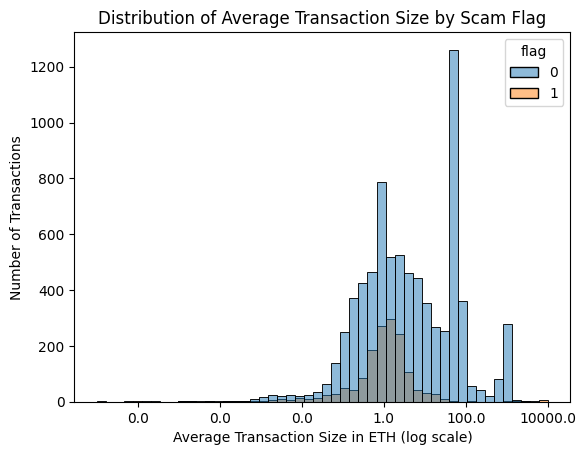

In [24]:
df['total_value'] = df['total_ether_sent'] + df['total_ether_received']
df['tx_count'] = df['sent_tnx'] + df['received_tnx']
df['avg_tx_size'] = df['total_value'] / (df['tx_count'] + 1e-5)

# Plot
fig, ax = plt.subplots()
sns.histplot(
    data=df[df['avg_tx_size'].notna() & df['flag'].notna()],
    x='avg_tx_size',
    hue='flag',
    bins=50,
    log_scale=True,
    ax=ax
)

# Format x-axis labels
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_ylabel('Number of Transactions') 
plt.title('Distribution of Average Transaction Size by Scam Flag')
plt.xlabel('Average Transaction Size in ETH (log scale)')
plt.show()

### Summary of Distribution of Average Transaction Sizes

This histogram shows the distribution of average transaction sizes per address in ETH (log scale). 

- The x-axis represents the average transaction size.
- The y-axis shows the number of addresses in each bin.

We observe that most addresses have average transaction sizes between 0.01 and 100 ETH, with some outliers on both the small and large ends. Differences between scam and non-scam addresses are highlighted by the color hues.

---

<br><br>

## Section 4: Transaction Frequency per Address
* Are scams more or less active
* What’s the distribution of transaction counts per address

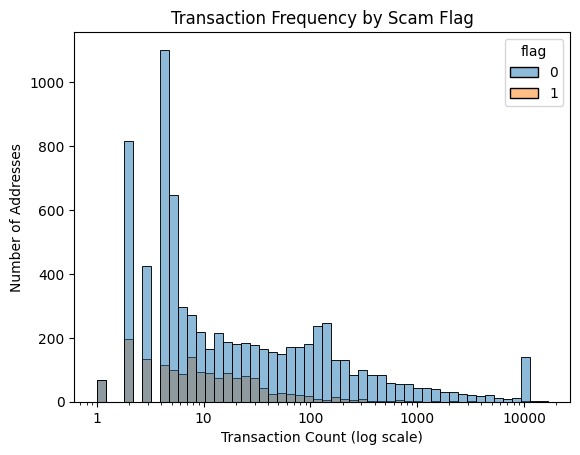

In [28]:
sns.histplot(data=df, x='tx_count', hue='flag', bins=50, log_scale=True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))

plt.title('Transaction Frequency by Scam Flag')
plt.ylabel('Number of Addresses')
plt.xlabel('Transaction Count (log scale)')
plt.show()

### Summary Transaction Frequency by Scam Flag

This plot shows how frequently addresses transact on Ethereum.

- The x-axis shows the total transaction count per address (log scale).
- The y-axis represents the number of addresses with that transaction count.

This visualisation helps compare activity levels between scam and non-scam addresses.

In [39]:
df.to_csv('../Data/Features/feature_ethereum_data_with_ratios.csv', index=False)